In [22]:
# Import standard libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_context('talk', font_scale = 1.05)

### Load data

In [23]:
df = pd.read_csv("C:\\Users\\juhic\\OneDrive\\Desktop\\DubsTech Datathon\\data.csv")
df['collection_week'] = pd.to_datetime(df['collection_week'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742253 entries, 0 to 742252
Columns: 128 entries, hospital_pk to total_staffed_pediatric_icu_beds_7_day_sum
dtypes: bool(2), datetime64[ns](1), float64(87), int64(29), object(9)
memory usage: 714.9+ MB


### Load required columns (sum only)

In [24]:
df2 = pd.read_excel("eda.xlsx", sheet_name = "columns")
df3 = pd.read_excel("eda.xlsx", sheet_name = "base_columns")

columns = list(df3['Name']) + list(df2['sum_columns'])
df = df[columns]

### Handle nulls & -9999 data records

In [25]:
df.fillna(0, inplace = True)
df.replace(to_replace = -999999, value = 2, inplace = True)

### Group by at given granularity

#### 1. State

In [26]:
# drop select base columns
drop_cols = ['hospital_pk','ccn','hospital_name','address','city','zip','hospital_subtype','fips_code',
             'is_metro_micro','geocoded_hospital_address','hhs_ids','is_corrected']
df_temp = df.drop(columns = drop_cols)

# group at state-week
df_state = df_temp.groupby(by = ['collection_week','state'], as_index = False).sum()

# sort dataframe at week level
df_state.sort_values(['state', 'collection_week'], ascending=[True, True], inplace=True)
df_state.reset_index(drop = True, inplace = True)
df_state.head()

,collection_week,state,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
0,2020-03-20,AK,324.0,0.0,0.0,72.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-27,AK,1783.0,0.0,0.0,586.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-03,AK,9304.0,0.0,0.0,3486.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-10,AK,8667.0,0.0,0.0,2676.0,0.0,58.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-17,AK,7031.0,0.0,0.0,1840.0,0.0,167.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Select Features

In [ ]:
req_cols = ['state',
             'collection_week',
             'inpatient_beds_used_covid_7_day_sum',
            'all_adult_hospital_beds_7_day_sum',
            'all_adult_hospital_inpatient_beds_7_day_sum',
            'inpatient_beds_used_7_day_sum',
            'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
            'inpatient_beds_7_day_sum',
            'total_patients_hospitalized_confirmed_influenza_7_day_sum',
            'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum',
            'all_pediatric_inpatient_bed_occupied_7_day_sum',
            'staffed_icu_pediatric_patients_confirmed_covid_7_day_sum',
            'previous_day_admission_adult_covid_confirmed_7_day_sum',
            'previous_day_covid_ED_visits_7_day_sum',
            'previous_day_admission_influenza_confirmed_7_day_sum',
            'previous_week_personnel_covid_vaccinated_doses_administered_7_day',
            'total_personnel_covid_vaccinated_doses_none_7_day',
            'previous_week_patients_covid_vaccinated_doses_all_7_day']

df_state = df_state[req_cols]

In [27]:
req_cols = ['state',
            'collection_week',
            'inpatient_beds_used_covid_7_day_sum',
            'inpatient_beds_used_7_day_sum',
            'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum',
            'all_pediatric_inpatient_bed_occupied_7_day_sum',
            'staffed_icu_pediatric_patients_confirmed_covid_7_day_sum',
            'previous_day_admission_adult_covid_confirmed_7_day_sum',
            'previous_day_covid_ED_visits_7_day_sum',
            'previous_day_admission_influenza_confirmed_7_day_sum',
            'previous_week_personnel_covid_vaccinated_doses_administered_7_day',
            'total_personnel_covid_vaccinated_doses_none_7_day',
            'previous_week_patients_covid_vaccinated_doses_all_7_day']

df_state = df_state[req_cols]

In [28]:
df_state2 = df_state.loc[df_state['state'] == 'CA']
df_state2.drop(columns = 'state', inplace = True)

df_state2.set_index(keys = 'collection_week', inplace = True)
df_state2.head()

,inpatient_beds_used_covid_7_day_sum,inpatient_beds_used_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
collection_week,,,,,,,,,,,
2020-01-31,14.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,2.0,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-13,59.0,1650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-20,274.0,3465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split

In [29]:
# train-test split
train = df_state2[:-12]
test = df_state2[-12:]

In [39]:
test

,inpatient_beds_used_covid_7_day_sum,inpatient_beds_used_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
collection_week,,,,,,,,,,,
2022-11-25,28376.0,338098.0,694.0,18929.0,176.0,4367.0,62287.0,2962.0,30.0,9135.0,231.0
2022-12-02,33309.0,348292.0,827.0,20226.0,210.0,4848.0,57307.0,2374.0,46.0,5431.0,64.0
2022-12-09,34802.0,346840.0,778.0,19561.0,237.0,4692.0,52808.0,1749.0,34.0,9067.0,308.0
2022-12-16,34516.0,339802.0,552.0,18747.0,195.0,4571.0,50530.0,1549.0,17.0,16121.0,662.0
2022-12-23,33928.0,318984.0,559.0,16032.0,171.0,4923.0,50556.0,1482.0,23.0,16214.0,461.0
2022-12-30,35513.0,333840.0,458.0,16781.0,362.0,4895.0,48573.0,1099.0,7.0,16229.0,413.0
2023-01-06,32426.0,346867.0,295.0,17040.0,194.0,4069.0,42764.0,572.0,11.0,16228.0,707.0
2023-01-13,27118.0,337932.0,173.0,16424.0,185.0,3349.0,38626.0,296.0,11.0,16218.0,620.0
2023-01-20,22257.0,341209.0,108.0,17436.0,139.0,2711.0,37583.0,181.0,12.0,16027.0,524.0


### Model Building

In [30]:
model = VAR(train)
sorted_order = model.select_order(maxlags = 11)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        178.0       178.3   2.056e+77       178.1
1        156.7       159.6   1.138e+68       157.9
2        154.5       160.0   1.303e+67       156.7
3        153.4       161.5   4.742e+66       156.7
4        152.8       163.6   3.211e+66       157.2
5        152.6       166.0   3.594e+66       158.1
6        152.2       168.3   4.007e+66       158.8
7        152.0       170.7   7.047e+66       159.6
8        150.0       171.3   3.131e+66       158.7
9        147.0       170.9   1.029e+66       156.8
10       142.4       168.9   2.300e+65       153.2
11      125.0*      154.2*  3.564e+60*      136.9*
--------------------------------------------------


In [31]:
var_model = VARMAX(train, order = (4,0), enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

                                                                                                                                                                                                                                                                                                                         Statespace Model Results                                                                                                                                                                                                                                                                                                                         
Dep. Variable:     ['inpatient_beds_used_covid_7_day_sum', 'inpatient_beds_used_7_day_sum', 'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum', 'all_pediatric_inpatient_bed_occupied_7_day_sum', 'staffed_icu_pediatric_patients_confirmed_covid_7_day_sum', 'previous_day_admission_adult_covid_confirmed_7_day_sum', 'previous_day_covi

In [32]:
n_forecast = 12
predict = fitted_model.get_prediction(start = len(train), end = len(train)+n_forecast-1)
predictions = predict.predicted_mean

In [40]:
predictions

,inpatient_beds_used_covid_7_day_sum,inpatient_beds_used_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
144,23115.107014,397647.851762,399.149871,23863.095811,-22.058987,4493.036174,69970.842350,1378.305360,1745.983125,45390.766568,25014.920106
145,32957.329055,430243.243531,427.158902,23196.072766,33.311359,6004.207609,77368.494816,1263.117366,13768.412163,71099.350287,36618.678762
146,46134.817214,432907.508552,420.896378,21170.562070,120.199063,7536.228373,79480.347847,1044.375861,22224.757696,96478.218097,43855.879607
147,56371.888869,424892.312424,397.709231,18935.986174,205.307394,8625.768686,79074.951015,844.667447,28484.340631,113694.018287,49743.541985
148,63867.368043,403076.046371,395.057301,18984.417759,252.600515,9465.298881,79403.555568,720.070223,22629.522758,114606.061928,48667.735389
149,67595.594890,381741.955187,350.788964,18027.129500,314.539269,9694.661779,76374.310799,576.455989,22183.927686,123190.956726,50077.297684
150,66114.171101,370321.358000,305.085637,17758.007154,337.825903,9259.289508,72146.053178,462.121735,21492.910568,126325.522773,47916.735371
151,61325.331047,362445.306661,260.097230,17807.217612,346.384809,8497.802242,67724.453462,372.651142,20059.389226,125628.504139,45053.672221
152,54539.158434,357643.702579,216.848894,18361.983840,338.468282,7584.947371,63834.101027,301.682319,18181.244969,123690.049497,43384.811378
153,45383.498353,354649.091534,164.096485,18681.864826,317.439639,6382.516520,58977.763972,242.105551,15955.738941,121606.342441,41679.976446


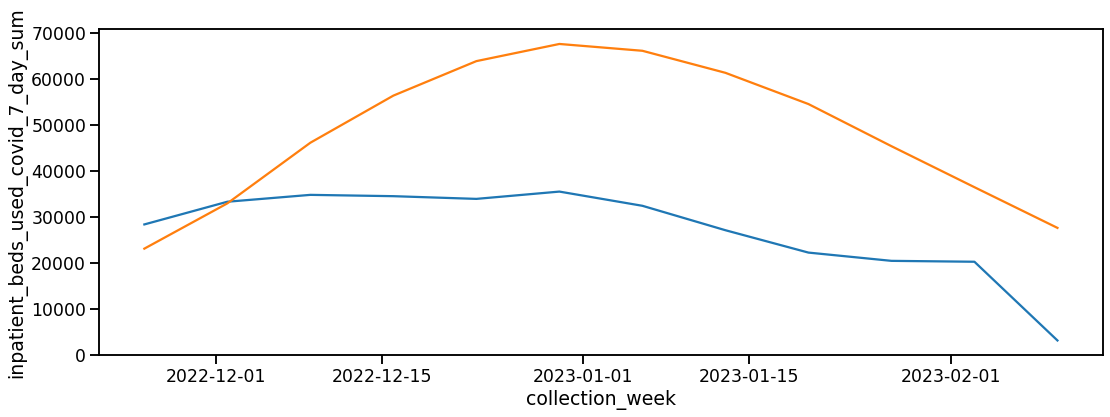

In [41]:
fig = plt.subplots(figsize = (18,6))
y = 'inpatient_beds_used_covid_7_day_sum'
sns.lineplot(x = test.index, y = y, data = test)
sns.lineplot(x = test.index, y = y, data = predictions)
plt.show()

In [35]:
df_state2.index

DatetimeIndex(['2020-01-31', '2020-02-28', '2020-03-06', '2020-03-13',
               '2020-03-20', '2020-03-27', '2020-04-03', '2020-04-10',
               '2020-04-17', '2020-04-24',
               ...
               '2022-12-09', '2022-12-16', '2022-12-23', '2022-12-30',
               '2023-01-06', '2023-01-13', '2023-01-20', '2023-01-27',
               '2023-02-03', '2023-02-10'],
              dtype='datetime64[ns]', name='collection_week', length=156, freq=None)

In [36]:
predictions

,inpatient_beds_used_covid_7_day_sum,inpatient_beds_used_7_day_sum,total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum,all_pediatric_inpatient_bed_occupied_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
144,23115.107014,397647.851762,399.149871,23863.095811,-22.058987,4493.036174,69970.842350,1378.305360,1745.983125,45390.766568,25014.920106
145,32957.329055,430243.243531,427.158902,23196.072766,33.311359,6004.207609,77368.494816,1263.117366,13768.412163,71099.350287,36618.678762
146,46134.817214,432907.508552,420.896378,21170.562070,120.199063,7536.228373,79480.347847,1044.375861,22224.757696,96478.218097,43855.879607
147,56371.888869,424892.312424,397.709231,18935.986174,205.307394,8625.768686,79074.951015,844.667447,28484.340631,113694.018287,49743.541985
148,63867.368043,403076.046371,395.057301,18984.417759,252.600515,9465.298881,79403.555568,720.070223,22629.522758,114606.061928,48667.735389
149,67595.594890,381741.955187,350.788964,18027.129500,314.539269,9694.661779,76374.310799,576.455989,22183.927686,123190.956726,50077.297684
150,66114.171101,370321.358000,305.085637,17758.007154,337.825903,9259.289508,72146.053178,462.121735,21492.910568,126325.522773,47916.735371
151,61325.331047,362445.306661,260.097230,17807.217612,346.384809,8497.802242,67724.453462,372.651142,20059.389226,125628.504139,45053.672221
152,54539.158434,357643.702579,216.848894,18361.983840,338.468282,7584.947371,63834.101027,301.682319,18181.244969,123690.049497,43384.811378
153,45383.498353,354649.091534,164.096485,18681.864826,317.439639,6382.516520,58977.763972,242.105551,15955.738941,121606.342441,41679.976446
